In [2]:
import pandas as pd
import numpy as np
import pickle
import itertools

mi = 'U1'; t='PP'
# df = pd.read_csv('data/preprocessed_packing/'+mi+'.csv')
df = pd.read_csv('data/preprocessed_packing/'+mi+'_'+t+'_2.csv')# save
bbox_master = pd.read_csv('data/preprocessed_tables/'+mi+'_bbox.csv')
with open('data/preprocessed_packing/'+mi + '_'+ t +'_r.pickle', 'rb') as handle: data = pickle.load(handle)

# scaling
for i in range(len(data)): data[i] = data[i]//10
print(bbox_master.values[[0,1,2,16]]//10)
# bbox_master = np.ceil(( bbox_master.values * 0.95)/10).astype('int')
bbox_master = np.ceil(( bbox_master.values)/10).astype('int')
bbox_master = bbox_master[[0,1,2,16]]
print(bbox_master)

def get_bbox_stan(max_l, max_b, max_h, bbox_type):
    bbox_stan = np.zeros((max_l, max_b, max_h))
    l,b,h = bbox_type
    bbox_stan[l:,:,:] = 1
    bbox_stan[:,b:,:] = 1
    bbox_stan[:l, :b, :max_h-h] = 1
    return bbox_stan

def get_bbox_idx(n_bbox =4, k=2):
    # k는 박스 수
    x = list(range(4))
    idx = np.array([p for p in itertools.product(x, repeat=k)])
    idx = np.sort(idx, axis=1)
    idx = np.unique(idx, axis=0)
    return idx

def pad_bbox(n_boxes, bbox_stan, max_l, max_b, max_h, i=0):
    padded = np.ones(( max_l, max_b, max_h, n_boxes ))
    padded[:max_l, :max_b, :max_h, i] = bbox_stan
    return padded

def pad_bbox_multi(n_boxes, bbox_stans, max_l, max_b, max_h):
    padded = np.ones(( max_l, max_b, max_h, n_boxes ))
    for i in range(len(bbox_stans)):
        padded[:max_l, :max_b, :max_h, i] = bbox_stans[i]
    return padded

def merge_bboxes(bboxes):
    l, b, h, n = bboxes.shape
    n = n//2
    merged = np.zeros(( l*n+1, b*n+1, h))
    merged = merged + h
    merged[:l, :b] = bboxes[:,:,:,0]
    merged[l+1:, :b] = bboxes[:,:,:,1]
    merged[:l, b+1:] = bboxes[:,:,:,2]
    merged[l+1:, b+1:] = bboxes[:,:,:,3]
    return merged

[[119 113  50]
 [148 113 110]
 [119 113  36]
 [198 114  61]]
[[119 113  50]
 [148 113 110]
 [119 113  36]
 [198 114  61]]


In [3]:
max_l = np.max(bbox_master[:,0])
max_b = np.max(bbox_master[:,1])
max_h = np.max(bbox_master[:,2])
n_boxes = 4

# 박스 한 개
bboxes1 = []
for b in bbox_master:
    bbox_stan = get_bbox_stan(max_l, max_b, max_h, b)
    padded = pad_bbox(n_boxes, bbox_stan, max_l, max_b, max_h, i=0)
    bboxes1.append(padded)
bboxes1 = np.stack(bboxes1).astype('int')
    
# 박스 두 개
bboxes2 = []
for i,j in get_bbox_idx(n_boxes, 2):
    bbox_stan1 = get_bbox_stan(max_l, max_b, max_h, bbox_master[i])
    bbox_stan2 = get_bbox_stan(max_l, max_b, max_h, bbox_master[j])
    bbox_stans = [bbox_stan1, bbox_stan2]
    padded = pad_bbox_multi(n_boxes, bbox_stans, max_l, max_b, max_h)
    bboxes2.append(padded)
bboxes2 = np.stack(bboxes2).astype('int')

# 박스 세개
bboxes3 = []
for i,j,k in get_bbox_idx(n_boxes, 3):
    bbox_stan1 = get_bbox_stan(max_l, max_b, max_h, bbox_master[i])
    bbox_stan2 = get_bbox_stan(max_l, max_b, max_h, bbox_master[j])
    bbox_stan3 = get_bbox_stan(max_l, max_b, max_h, bbox_master[k])
    bbox_stans = [bbox_stan1, bbox_stan2, bbox_stan3]
    padded = pad_bbox_multi(n_boxes, bbox_stans, max_l, max_b, max_h)
    bboxes3.append(padded)
bboxes3 = np.stack(bboxes3).astype('int')

# 박스 네개
bboxes4 = []
for i,j,k,w in get_bbox_idx(n_boxes, 4):
    bbox_stan1 = get_bbox_stan(max_l, max_b, max_h, bbox_master[i])
    bbox_stan2 = get_bbox_stan(max_l, max_b, max_h, bbox_master[j])
    bbox_stan3 = get_bbox_stan(max_l, max_b, max_h, bbox_master[k])
    bbox_stan4 = get_bbox_stan(max_l, max_b, max_h, bbox_master[w])
    bbox_stans = [bbox_stan1, bbox_stan2, bbox_stan3, bbox_stan4]
    padded = pad_bbox_multi(n_boxes, bbox_stans, max_l, max_b, max_h)
    bboxes4.append(padded)
bboxes4 = np.stack(bboxes4).astype('int')

bboxes1_m = np.stack([merge_bboxes(b) for b in bboxes1]).astype('int')
bboxes2_m = np.stack([merge_bboxes(b) for b in bboxes2]).astype('int')
bboxes3_m = np.stack([merge_bboxes(b) for b in bboxes3]).astype('int')
bboxes4_m = np.stack([merge_bboxes(b) for b in bboxes4]).astype('int')

bboxes1.shape, bboxes2.shape, bboxes3.shape, bboxes4.shape, bboxes1_m.shape, bboxes2_m.shape, bboxes3_m.shape, bboxes4_m.shape

((4, 198, 114, 110, 4),
 (10, 198, 114, 110, 4),
 (20, 198, 114, 110, 4),
 (35, 198, 114, 110, 4),
 (4, 397, 229, 110),
 (10, 397, 229, 110),
 (20, 397, 229, 110),
 (35, 397, 229, 110))

In [124]:
def make_ax(sub, grid=False):
    #fig = plt.figure()
    #ax = fig.gca(projection='3d')
    if isinstance(sub, list):
        ax = plt.subplot(sub[0],sub[1],sub[2], projection='3d')
    else:
        ax = plt.subplot(sub, projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax
# def plot_voxel(t, sub):
#     ax = make_ax(sub, True)
#     ax.voxels(t,  edgecolors='black', shade=False, alpha = 0.8)
#     plt.show()
    397, 229, 110
def plot_voxels(bboxes_m, subs, fig, titles):
    plt.figure(figsize=fig)
    
    for bboxes, sub, title in zip(bboxes_m, subs, titles):
        ax = make_ax(sub, True)
        plt.title(title, fontsize=12)
        ax.voxels(bboxes[::50,::30,::15], edgecolors='black',
                 shade=False, alpha=0.8)

In [125]:
box_list = [[119, 113,  50],
            [148, 113, 110],
            [119, 113,  36],
            [198, 114,  61]]

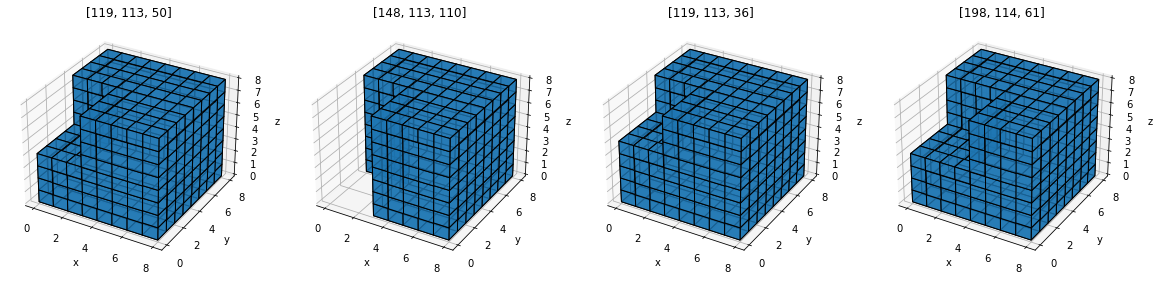

In [126]:
title_list = []
for box in box_list:
    title_list.append(str(box))

plot_voxels(bboxes1_m, [141,142,143,144], fig=(20,5), titles=title_list)

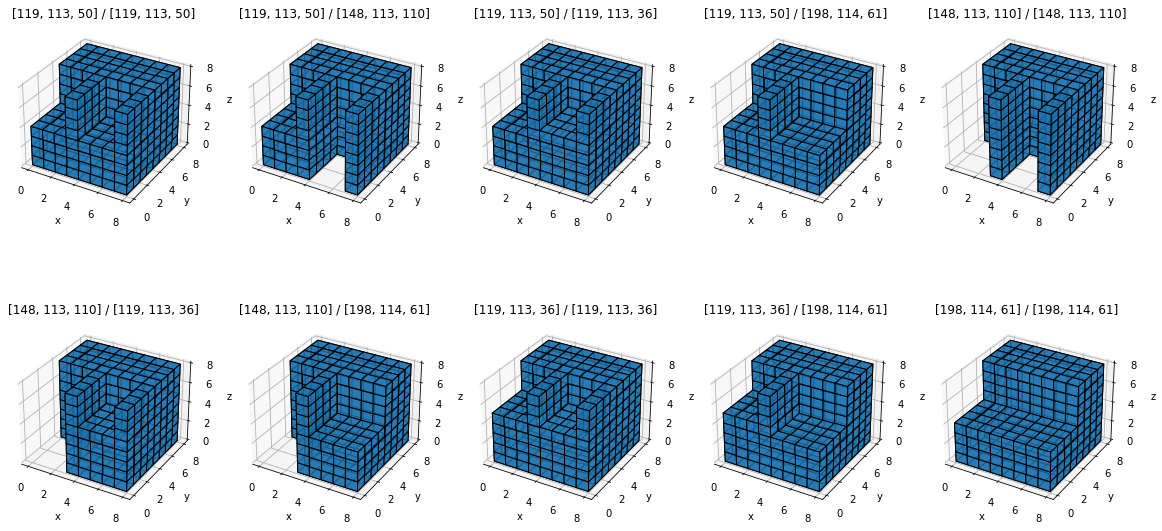

In [127]:
sub = []
for i in range(1, 11):
    sub.append([2,5,i])
title_list = []
for i in range(4):
    for j in range(i, 4):
        title_list.append(str(box_list[i]) + ' / ' + str(box_list[j]))
plot_voxels(bboxes2_m, sub, fig=(20,10), titles = title_list)

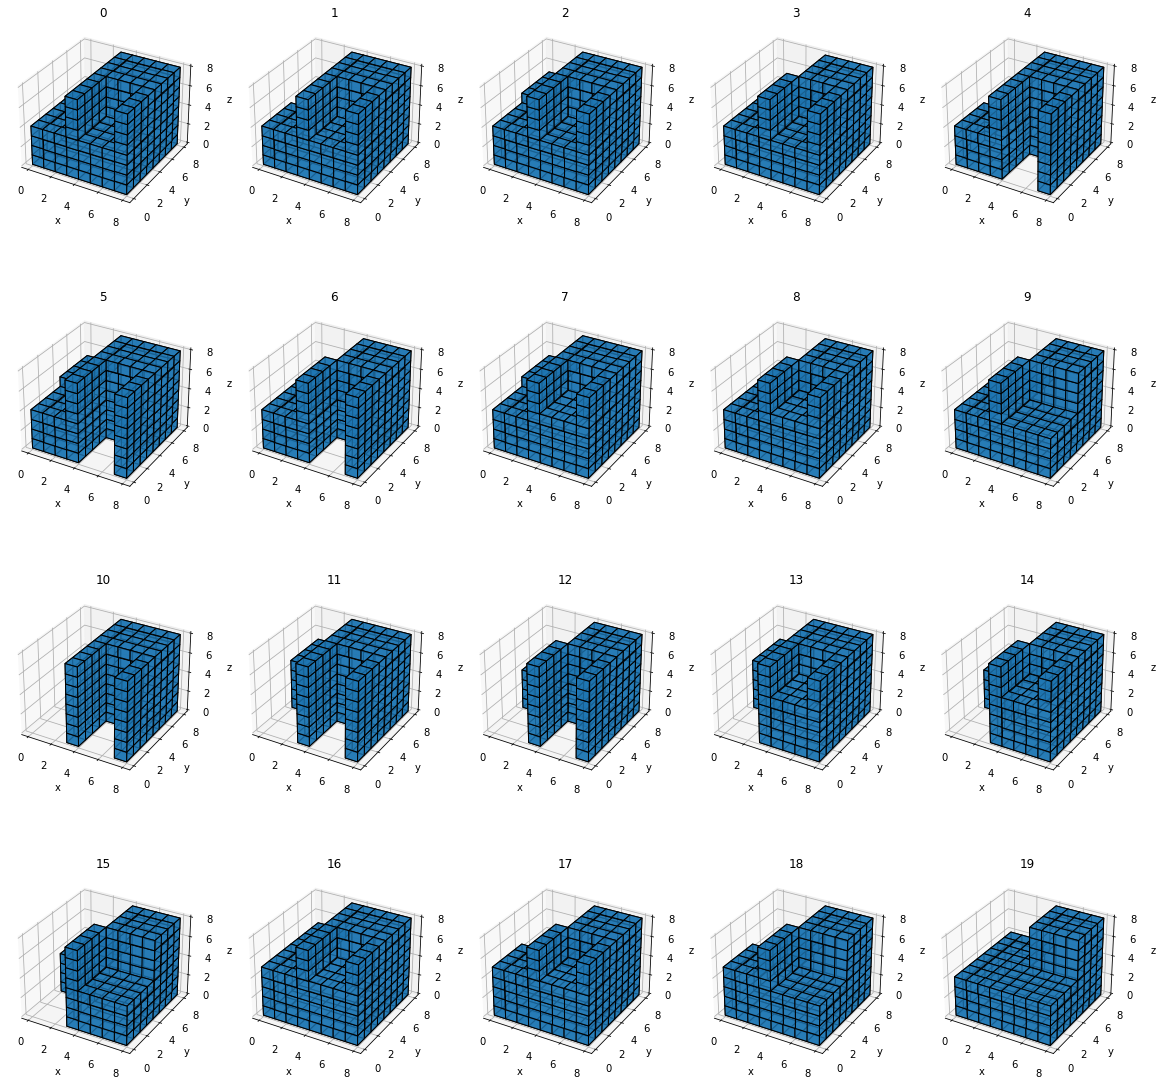

In [128]:
sub = []
for i in range(1, 21):
    sub.append([4,5,i])
plot_voxels(bboxes3_m, sub, fig=(20,20), titles = [x for x in range(20)])

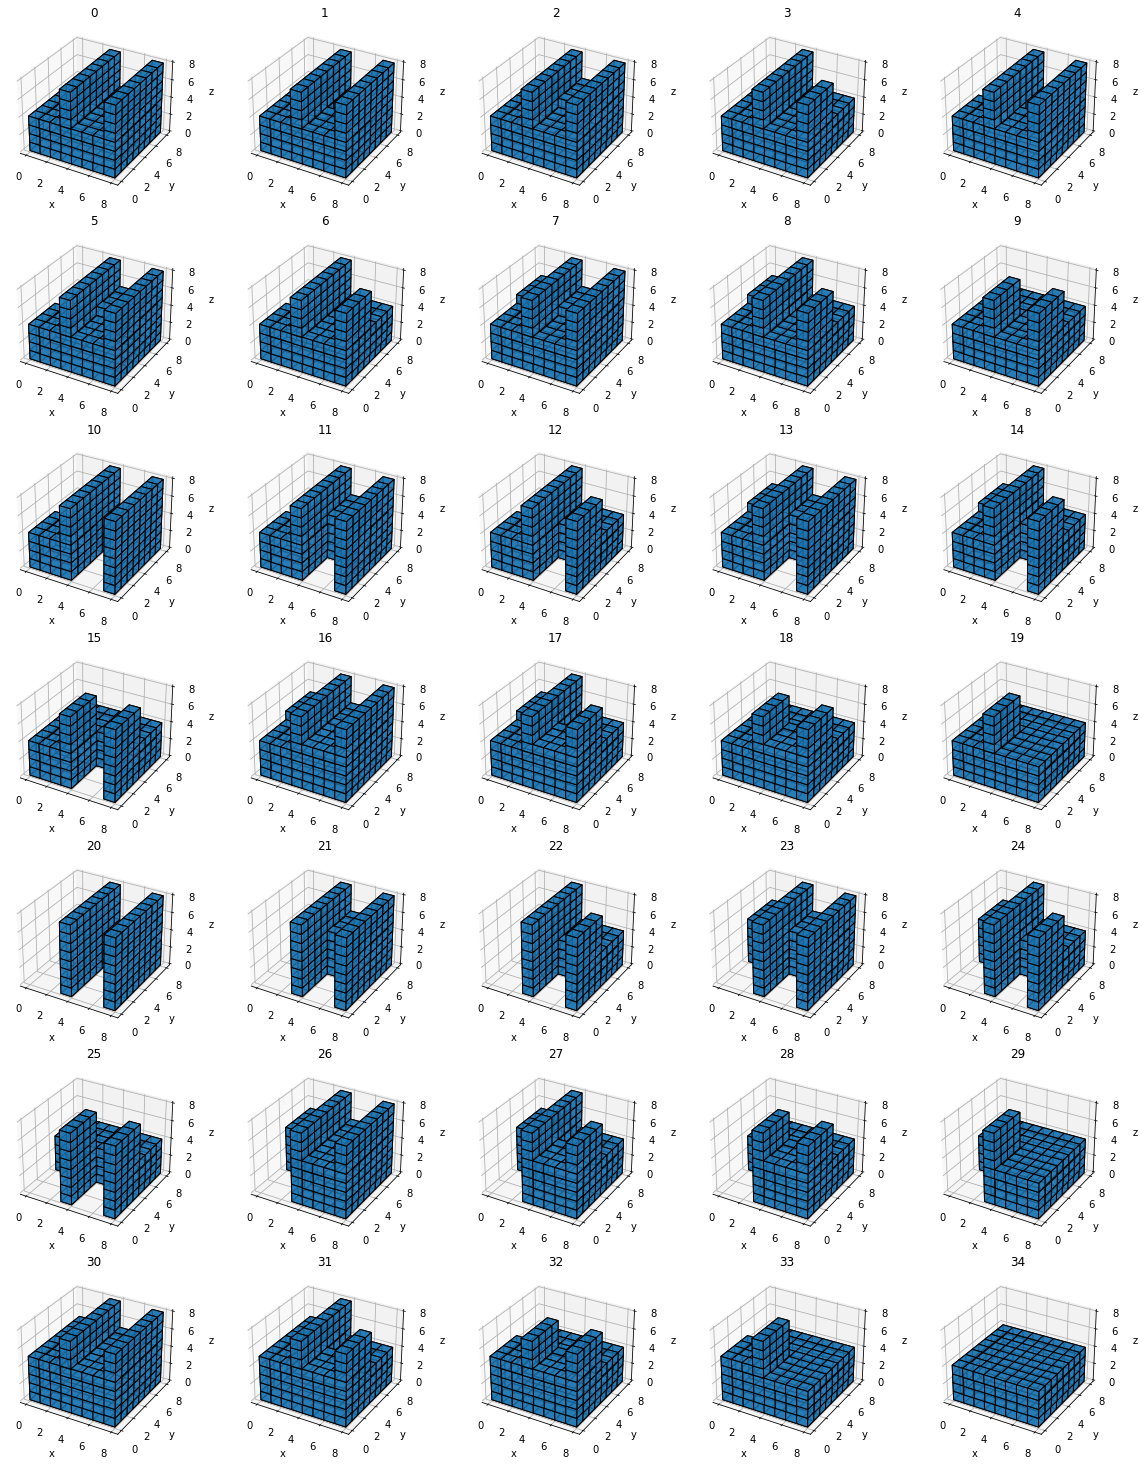

In [129]:
sub = []
for i in range(1, 36):
    sub.append([8,5,i])
plot_voxels(bboxes4_m, sub,fig=(20,30), titles = [x for x in range(35)])

In [28]:
bboxes1_m[0][::10,::10,::10].shape

(40, 23, 11)

In [26]:
bboxes1_m[0].shape

(397, 229, 110)

In [ ]:
class Bpp3DEnv():
    def __init__(self,length=20, breadth=20, height=20):
        super(Bpp3DEnv, self).__init__()
        self.length=length
        self.breadth=breadth
        self.height=height
        self.container_h=np.zeros((self.length,self.breadth))
        self.container=np.zeros((self.length, self.breadth, self.height))
    
    def update_h(self):
        idx = np.where(self.container == 1)
        h = pd.DataFrame(np.transpose(idx, (1,0)))
        h.columns = ['0','1','2']
        h = h.groupby(['0','1']).agg({'0':'first','1':'first','2':'max'}).values
        self.reset_h()
        self.container_h[h[:,0],h[:,1]] = h[:,2]+1
        return self.container_h
    
    def convert_state(self, new_container):
        self.container = new_container
        self.update_h()
    
    def next_state(self, upleft,bxl,bxb,bxh):
        next_container_h = self.container_h.copy()
        loading_area_h = self.container_h[upleft[0]:upleft[0]+bxl, upleft[1]:upleft[1]+bxb]
        max_h = np.max(loading_area_h).astype('int')
        next_container_h[upleft[0]:upleft[0]+bxl,upleft[1]:upleft[1]+bxb] = bxh + max_h
        
        next_container = self.container.copy()
        next_container[upleft[0]:upleft[0]+bxl, upleft[1]:upleft[1]+bxb, max_h:bxh + max_h] = 1
        
        return next_container, next_container_h
    
    def step(self, upleft,bxl,bxb,bxh):
        n_s, n_h = self.next_state(upleft,bxl,bxb,bxh)
        self.convert_state(n_s)
        return n_s
    
    def reset(self):
        self.container = np.zeros((self.length,self.breadth, self.height))
        self.container_h = np.zeros((self.length,self.breadth))
    
    def reset_h(self):
        self.container_h = np.zeros((self.length,self.breadth))
        
    def terminal_reward(self):
        return np.sum(self.container)/(self.length*self.breadth*self.height)